# CPSC 330 - Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 
### Associated lectures: [Lectures 7, 8](https://github.com/UBC-CS/cpsc330-2022W2) 

**Due date: Feb 10, 11:59pm**


## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

## Instructions 
<hr>
rubric={points:6}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- **Be kind** and respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

<br><br><br><br>

## Exercise 1: Implementing `DummyClassifier` 
<hr>
rubric={points:25}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: 
- `fit` can return nothing, 
- `predict` returns an array whose size is the number of examples, 
- `predict_proba` returns an array whose size is the number of examples x 2, and 
- `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [2]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """
    
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.class_count = {}
        self.highest_frequency = 0
        self.most_frequent_class = 0
        self.total = 0
    
    def fit(self, X, y):
        self.total = X.shape[0]
        
        for result in y:
            if result in self.class_count:
                self.class_count[result] += 1
            else:
                self.class_count[result] = 1
                
        for result, frequency in self.class_count.items():
            if frequency > self.highest_frequency:
                self.highest_frequency = frequency
                self.most_frequent_class = result

    def predict(self, X):
        
        prediction_array = []
        for i in range(X.shape[0]):
            prediction_array.append(self.most_frequent_class)
        results = np.asarray(prediction_array)
            
        return results

    def predict_proba(self, X):
        prediction_proba = []
        results = []
    
        for result in sorted(self.class_count):
            prediction_proba.append(self.class_count[result]/self.total)
            
        for i in range(X.shape[0]):
            results.append(prediction_proba)
        
        final = np.asarray(results)
        
        return final # Replace with your code

    def score(self, X, y):
        
        result = self.predict(X)
        number_correct = 0
        for i in range(len(result)):
            if result[i] == y[i]:
                number_correct += 1
        
        return number_correct/y.shape[0]  # Replace with your code

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [3]:
# For testing, generate random data
for i in range(10):
    n_train = 101
    n_valid = 21
    d = 5
    X_train_dummy = np.random.randn(n_train, d)
    X_valid_dummy = np.random.randn(n_valid, d)
    y_train_dummy = np.random.randint(2, size=n_train)
    y_valid_dummy = np.random.randint(2, size=n_valid)

    my_dc = MyDummyClassifier()
    sk_dc = DummyClassifier(strategy="prior")

    my_dc.fit(X_train_dummy, y_train_dummy)
    sk_dc.fit(X_train_dummy, y_train_dummy)

    assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
    assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

Below are some tests for `predict_proba`.

In [4]:
assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

Below are some tests for `score`.

In [5]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

<br><br><br><br>

## Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [6]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [7]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [8]:
y = tweets_df["retweets"] > 10_000
y

id
1698308935             False
1701461182             False
1737479987             False
1741160716             False
1773561338             False
                       ...  
1273405198698975232     True
1273408026968457216     True
1273442195161387008    False
1273442469066276864    False
1273442528411385858    False
Name: retweets, Length: 43352, dtype: bool

To make predictions, we'll be using only the content (text) of the tweet. 

In [10]:
X = tweets_df["content"]
X

id
1698308935             Be sure to tune in and watch Donald Trump on L...
1701461182             Donald Trump will be appearing on The View tom...
1737479987             Donald Trump reads Top Ten Financial Tips on L...
1741160716             New Blog Post: Celebrity Apprentice Finale and...
1773561338             "My persona will never be that of a wallflower...
                                             ...                        
1273405198698975232    Joe Biden was a TOTAL FAILURE in Government. H...
1273408026968457216    Will be interviewed on @ seanhannity tonight a...
1273442195161387008                           pic.twitter.com/3lm1spbU8X
1273442469066276864                           pic.twitter.com/vpCE5MadUz
1273442528411385858                           pic.twitter.com/VLlc0BHW41
Name: content, Length: 43352, dtype: object

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
- Add a short comment to each block to describe what the code is doing.

In [13]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

# Instantiating a count vectorizer to count the number of instances of each word in each tweet
countvec = CountVectorizer(stop_words="english")

# Instantiating a logistic regression model 
lr = LogisticRegression(max_iter=1000)

# A pipeline is instantiated. When The first transformation involves passing our content through countvec 
# and generating features based on the count of words in each tweet
# After which, we pass the vectorised words into the logistic regression model
pipe = make_pipeline(countvec, lr)

# The training set is 5-fold cross-validated to preliminarily test the performance of the model to predict new data
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# The mean of the metrics for all folds performed in cross_validation is calculated
cross_val_results.mean()

fit_time       1.124241
score_time     0.124813
test_score     0.898475
train_score    0.967952
dtype: float64

<br><br>

#### 2(b) Cross-validation fold sub-scores
rubric={points:3}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. 
    - (Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores.)
- Are the 5 scores close to each other or spread far apart? 
  - (This is a bit subjective, answer to the best of your ability.)
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds?

In [14]:
cross_val_results

,fit_time,score_time,test_score,train_score
0,1.044204,0.126724,0.895587,0.966976
1,1.121152,0.128900,0.898047,0.968206
2,1.153003,0.115822,0.896971,0.967975
3,1.215375,0.139370,0.897893,0.968667
4,1.087471,0.113247,0.903876,0.967938


The five test_scores are close to each other.

In [15]:
X_train.shape

(32514,)

The size of this dataset is substantially larger than that of the cities dataset we have been using in class. This means that when we split the data into training and validation sets when we perform our various folds of cross-validation, we would have a significantly larger amount of training data for our model to learn the underlying distributions of the data better, resulting in better train and test scores in general.

<br><br>

#### 2(c) baseline
rubric={points:3}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset.
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
- Is it necessary to use `CountVectorizer` here? Briefly explain.

In [17]:
# Using CountVectorizer

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

# Instantiating a count vectorizer to count the number of instances of each word in each tweet
countvec = CountVectorizer(stop_words="english")

# Dummyclassifier is instantiated 
baseline = DummyClassifier(strategy="prior")

# A pipeline is instantiated. When The first transformation involves passing our content through countvec 
# and generating features based on the count of words in each tweet
# After which, we pass the vectorised words into the logistic regression model
pipe = make_pipeline(countvec, baseline)

# The training set is 5-fold cross-validated to preliminarily test the performance of the model to predict new data
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# The mean of each metric is produced.
cross_val_results.mean()

fit_time       0.435391
score_time     0.097096
test_score     0.735314
train_score    0.735314
dtype: float64

In [18]:
# Without using CountVectorizer

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

# Dummyclassifier is instantiated 
baseline = DummyClassifier(strategy="prior")

# The training set is 5-fold cross-validated to preliminarily test the performance of the model to predict new data
cross_val_results = pd.DataFrame(
    cross_validate(baseline, X_train, y_train, return_train_score=True)
)

# The mean of each metric is produced.
cross_val_results.mean()

fit_time       0.002194
score_time     0.000598
test_score     0.735314
train_score    0.735314
dtype: float64

Logistic Regression is performing much better than the `DummyClassifier`.

There is no need to use `CountVectorizer` here. Whether it is used or not, the test_score and train_score remain the same. This is because the `DummyClassifier` only considers the most frequent class label in the the observed `y` argument and does not consider the words present in our tweet.

<br><br>

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)
pipe = make_pipeline(countvec, lr)
pipe.fit(X_train, y_train);

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

In [24]:
pipe.classes_

array([False,  True])

In [48]:
# From Lecture 7
probs = pipe.predict_proba(X_test)[
    :, 1
]
probs

array([1.10067125e-02, 1.89407739e-03, 8.68363045e-01, ...,
       4.71620223e-04, 4.89197370e-03, 2.52170481e-04])

In [51]:
# From Lecture 7
most_viral = np.argmin(probs)

In [52]:
# From Lecture 7
X_train.iloc[most_viral]

'Many dead, including women and children, in mindless CHEMICAL attack in Syria. Area of atrocity is in lockdown and encircled by Syrian Army, making it completely inaccessible to outside world. President Putin, Russia and Iran are responsible for backing Animal Assad. Big price...'

<br><br>

#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:


In [21]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

Using these extracted components above, display
- the 5 words with the highest coefficients and 
- the 5 words with the smallest coefficients.

In [22]:
coefs=lr_from_pipe.coef_[0]
top_five = np.argpartition(coefs, -5)[-5:] #indices of top 5 features
top_five_words = []
for x in top_five:
    top_five_words.append(vec_from_pipe.get_feature_names_out()[x])


bottom_five = np.argpartition(coefs, 5)[:5] #indices of bottom 5 features
bottom_five_words = []
for x in bottom_five:
    bottom_five_words.append(vec_from_pipe.get_feature_names_out()[x])
    
print("The five words with the highest coefficients are: ", top_five_words, "\n")
print("The five words with the smallest coefficients are: ", bottom_five_words, "\n")


The five words with the highest coefficients are:  ['fake', 'mini', 'coronavirus', 'harassment', 'obamagate'] 

The five words with the smallest coefficients are:  ['donaldtrump', 'barackobama', 'trump2016pic', 'realdonaldtrump', 'celebapprentice'] 



<br><br>

#### 2(f) Running a cross-validation fold without sklearn tools 
rubric={points:8}

Sklearn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. 

**Your tasks:**

1. Compute logistic regression's validation score on the first fold, that is, train on 80% and validate on 20% of the training data (`X_train`) without using sklearn `Pipeline` or `cross_validate` or `cross_val_score`. Store the score of the fold in a variable called `fold_score`. Recall that `cross_validation` in `sklearn` does not shuffle the data by default.    

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split with `train_test_split` and `shuffle=False`):

In [23]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)
X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

X_cv_train_count_matrix = countvec.fit_transform(X_cv_train)
X_cv_test_count_matrix = countvec.transform(X_cv_test)

lr.fit(X_cv_train_count_matrix, y_cv_train)
fold_score = lr.score(X_cv_test_count_matrix, y_cv_test)
print(fold_score)

0.9038905120713517


<br><br><br><br>

## Exercise 3: hyperparameter optimization
<hr>

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. 

Based on the plot/output, what value of `max_features` seems best? Briefly explain.

> **Note:** the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

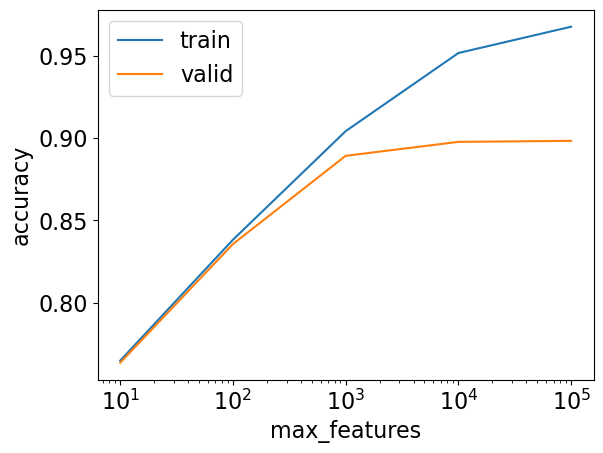

In [68]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [69]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.764701,0.763425
1,100,0.838270,0.835671
2,1000,0.904380,0.889371
3,10000,0.951936,0.897860
4,100000,0.967952,0.898475


Based on the plot, `max_features` = 1000 seems the best, as the cross validation accuracy is high while maintaining a short difference with the training accuracy. This is an indication that we are not overfitting our model to the training data, and also an indication that we are not underfitting out model such that it is unable to predict accurately on the validation data.

<br><br>

#### 3(b)
rubric={points:6}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. 

Based on the plot, what value of `C` seems best?

> **Note:** the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

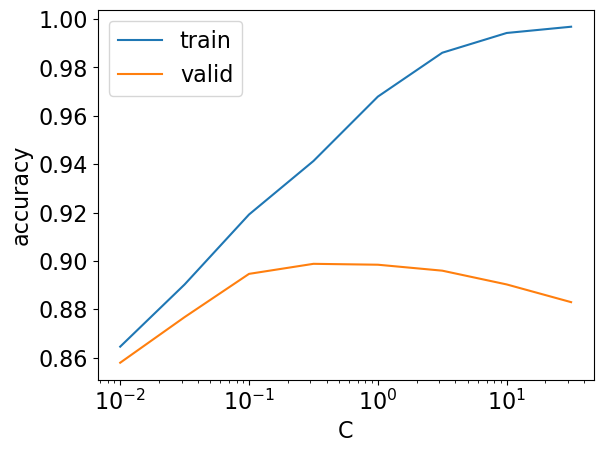

In [70]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-2, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [71]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.010000,0.864612,0.857969
1,0.031623,0.890316,0.876822
2,0.100000,0.919227,0.894692
3,0.316228,0.941333,0.898844
4,1.000000,0.967952,0.898475
5,3.162278,0.986091,0.896014
6,10.000000,0.994256,0.890324
7,31.622777,0.996840,0.883004


Based on the plot, `C` = $10^{-1}$ seems the best, as the cross validation accuracy is high while maintaining a short difference with the training accuracy.

<br><br>

#### 3(c) Hyperparameter optimization 
rubric={points:10}

Start with the pipeline `pipe` below.

**Your tasks:**
- Create a `GridSearchCV` object named `grid_search` to jointly optimize `max_features` of `CountVectorizer` and `C` of `LogisticRegression` across all the combinations of values we tried above. 
- What are the best values of `max_features` and `C` according to your grid search? 
- Store them in variables `best_max_features` and `best_C`, respectively.  
- Store the best score returned by the grid search in a variable called `best_score`. 

> The code might be a bit slow here. Setting `n_jobs=-1` should speed it up if you have a multi-core processor.

In [90]:
pipe = make_pipeline(
    CountVectorizer(stop_words="english"), 
    LogisticRegression(max_iter=1000)
)

param_grid = {
    "countvectorizer__max_features": [10, 100, 1000, 10_000, 100_000],
    "logisticregression__C": 10.0 ** np.arange(-2, 2, 0.5), 
}

grid_search = GridSearchCV(
    pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True
)

In [91]:
grid_search.fit(X_train, y_train) # all the work is done here
grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [10, 100, 1000, 10000,
                                                           100000],
                         'logisticregression__C': array([1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01])},
             return_train_score=True)

In [95]:
best_score = grid_search.best_score_
print(best_score)

0.8988437251093868


In [96]:
best_max_features = grid_search.best_params_['countvectorizer__max_features']
best_C = grid_search.best_params_['logisticregression__C']
print("Best max_features = ", best_max_features)
print("Best C = ", best_C)

Best max_features =  100000
Best C =  0.31622776601683794


<br><br>

#### 3(d) Discussion 
rubric={points:4}

- Do the best values of hyperparameters found by Grid Search agree with what you found in 3(a) and 3(b)? 
- **Generally speaking**, _should_ these values agree with what you found in parts  3.1 and 3.2? Why or why not? 

No, these best values do not agree with what we found in 3(a) and 3(b).

These values should not agree as they represent the best combination of values, but parts 3.1 and 3.2 represent individual best values. 

#### 3(e) Test score
rubric={points:2}

- Evaluate your final model on the test set. Store the test accuracy in the variable called `test_score`.

In [98]:
test_score = grid_search.score(X_test, y_test)
test_score

0.9018269053330873

#### 3(f) Discussion of Test Score
rubric={points:4}

- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

They are very similar. This makes sense as it is expected that the score on the test set be similar to that of best cross validation score.

## Exercise 4: Very short answer questions
rubric={points:8}

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
3. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?
4. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?

1. Because we do not want to fit our `CountVectorizer` with our test data. It should just be fitted with our training data. Hence, we just want to transform our test data into a vectorized form so that it can be fed into our logistic regression model.
2. I would access predict_proba, because it provides the confidence level which gives more context to the prediction.
3. The number of iterations can be specified in `RandomizedSearchCV`, unlike `GridSearchCV` which is exhaustive, this reduces the computation time. `RandomizedSearchCV` also allows for more chance that the 'useful' variables will be taken into account.
4. If we violate it, it means that our classifier was fed the test data, and when tested on the same test data again, it will produce unrealistically good scores.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 